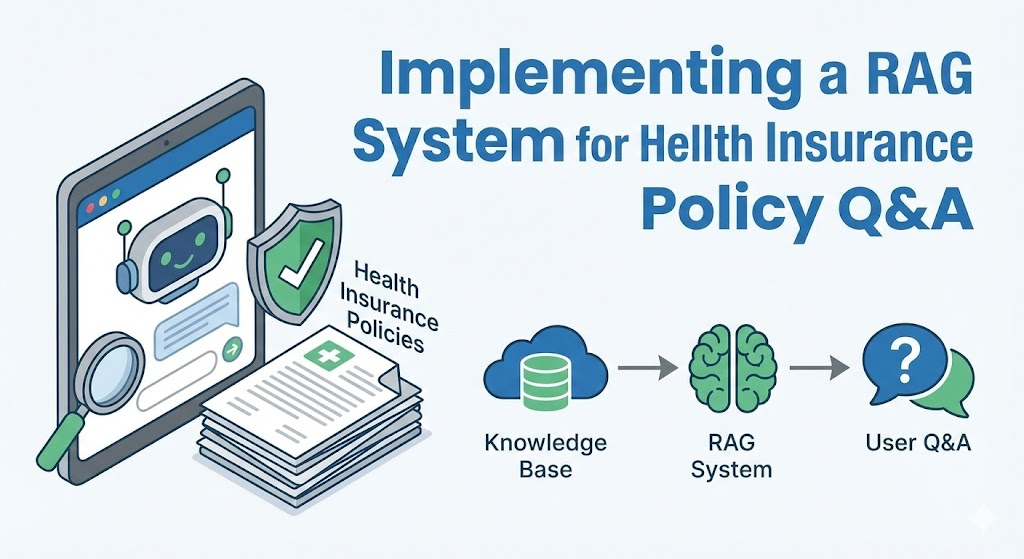

# Business Context
## Implementing a RAG System for Health Insurance Policy Q&A
**Problem Scenario:**

In today's unpredictable world, where healthcare costs continue to rise, having comprehensive health insurance is essential.

However, health insurance policy documents are often lengthy, complex, and difficult to understand.

As a result, many policyholders fail to fully read or comprehend their coverage details, discovering too late that certain treatments, diseases, or situations are excluded.

This lack of understanding can lead to claim denials and financial strain.

# Objective

To address these challenges, we propose implementing a **Retrieval-Augmented Generation (RAG) system** designed to simplify insurance policy comprehension.

This system will enable users to ask natural language questions, thereby improving the accessibility and understanding of health insurance policies.

By clarifying coverage upfront, customers can avoid surprises during claims, leading to increased satisfaction and retention.

The RAG application will simplify interactions with policy documents, allowing individuals to query specific aspects of their health insurance coverage and receive clear, concise explanations.

This will help customers better understand their policies before purchasing, ensuring they make informed decisions about their health coverage.

# The RAG pipeline will follow the format illustrated in the diagram below.

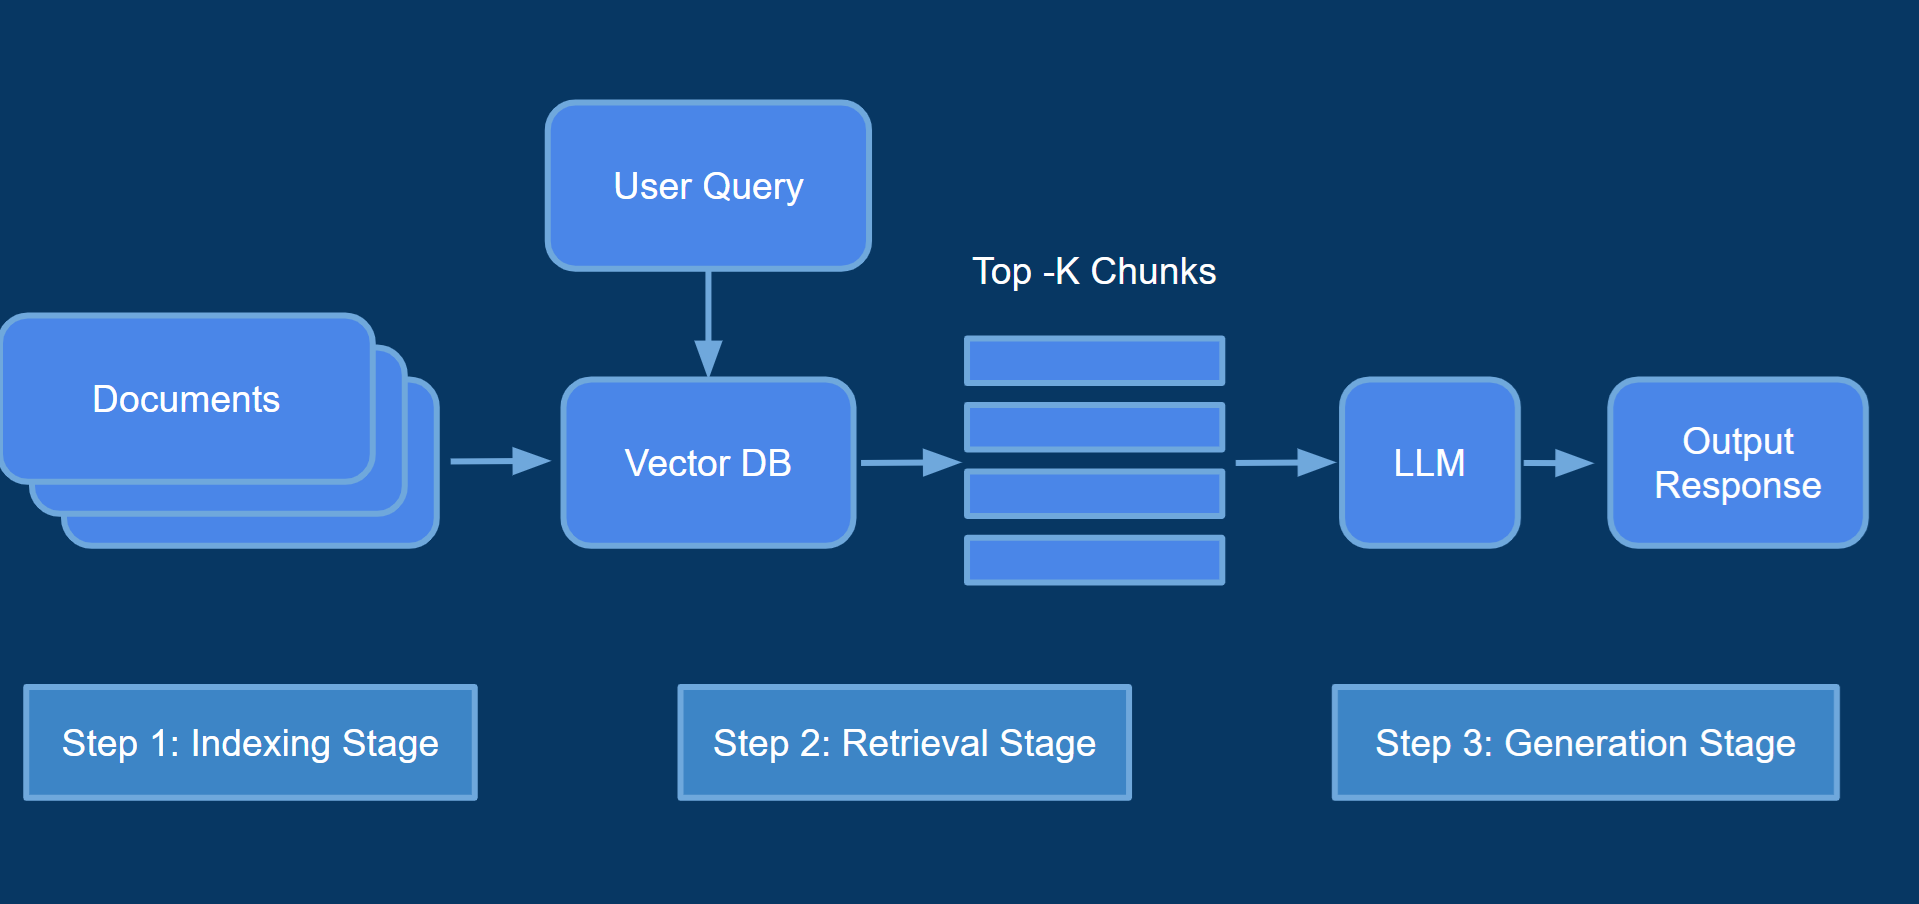

A typical RAG implementation consists of the following stages:
* Indexing Stage
* Retrieval Stage
* Generation Stage

| Stage          | Key Activities                                        | Role in RAG                              |
| -------------- | ----------------------------------------------------- | ---------------------------------------- |
| **Indexing**   | Chunking · Embedding · Storing                        | Prepares data for efficient retrieval    |
| **Retrieval**  | Query embedding · Similarity search   | Consolidates relevant context            |
| **Generation** | Prompt construction · LLM generation | Produces final response grounded in data |


### 1\.  Setup and Installation

First, we need to install the necessary Python libraries.

*   langchain & langgraph: Frameworks for building LLM applications.
    
*   langchain-google-genai: Connects to Google's Gemini models.
    
*   langchain-chroma: Connects to the Chroma vector database.
    
*   pypdf: Used to read PDF files.

In [1]:
# Install necessary libraries in one go to keep the environment clean
!pip install -qU langchain langchain-community langchain-google-genai langchain-chroma pypdf langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.4/157.4 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 713.3/713.3 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 19.6 MB/s eta 

### 2\.  Environment Configuration

We need to set up API keys.

1.  **LangSmith:** Used for tracing/debugging (optional but recommended to see how the agent thinks).
    
2.  **Google API Key:** Required to use Gemini models.
    

**Note:** This code uses userdata.get() which works in Google Colab. If running locally, you might use .env files instead.

In [2]:
import os
import getpass
from google.colab import userdata

# 1. Setup LangSmith for tracing (Optional: helps visualize the agent's steps)
try:
    Langsmith_api = userdata.get('Langsmith_api')
    os.environ["LANGSMITH_TRACING"] = "true"
    os.environ["LANGSMITH_API_KEY"] = Langsmith_api
except Exception as e:
    print("LangSmith API key not found. Tracing skipped.")

# 2. Setup Google Gemini API
try:
    os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
except Exception as e:
    # Fallback if not using Colab secrets
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google API Key: ")

### 3\.  Initialize Models

We need two types of models:

1.  **Chat Model (LLM):** The "brain" that generates answers (Gemini Flash).
    
2.  **Embedding Model:** Converts text into numbers (vectors) so we can perform mathematical similarity searches.

In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.chat_models import init_chat_model

# Initialize the Chat Model
# Note: Ensure the model name is valid. Standard naming is usually "gemini-1.5-flash"
model = init_chat_model("google_genai:gemini-2.5-flash-lite")

# Initialize the Embedding Model
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

### 4\.  Vector Store Setup

We use **Chroma** as our vector database. This is where our document data will be stored as numerical vectors.

*   persist\_directory: Saves the database to the disk so we don't have to rebuild it every time (optional).

In [4]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

### 5\.  Data Loading

Here we load the content from your PDF file (data.pdf).We use PyPDFLoader which extracts text page by page.

In [5]:
from langchain_community.document_loaders import PyPDFLoader

# Path to your file
file_path = "/content/RAG Systems Data PDF_Insurance Document.pdf"

# Load the document
loader = PyPDFLoader(file_path)
docs = loader.load()

# Basic verification
if docs:
    print(f"Loaded {len(docs)} pages.")
    print(f"Preview of page 1:\n{docs[0].page_content[:500]}...")
else:
    print("No documents loaded. Please check the file path.")

Loaded 48 pages.
Preview of page 1:
1. Preamble
 This 'Max Bupa Health Pulse' policy is a contract of insurance between You and Us which is subject to payment of full 
premium in advance and the terms, conditions and exclusions of this Policy. This Policy has been issued on the basis of the 
Disclosure to Information Norm, including the information provided by You in the Proposal Form and the Information 
Summary Sheet.
 Please inform Us immediately of any change in the address or any other changes aﬀecting You or any Insured Pers...


In [6]:
print(docs[0].page_content[:500])

1. Preamble
 This 'Max Bupa Health Pulse' policy is a contract of insurance between You and Us which is subject to payment of full 
premium in advance and the terms, conditions and exclusions of this Policy. This Policy has been issued on the basis of the 
Disclosure to Information Norm, including the information provided by You in the Proposal Form and the Information 
Summary Sheet.
 Please inform Us immediately of any change in the address or any other changes aﬀecting You or any Insured Pers


### 6\.  Text Splitting

LLMs have a limit on how much text they can read at once. Furthermore, smaller chunks make search more accurate.We use RecursiveCharacterTextSplitter to break the PDF into chunks of 1000 characters with a 200-character overlap (to maintain context between chunks).

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 219 sub-documents.


### 7\.  Indexing Documents (with Rate Limiting)

We now convert text chunks into vectors and store them in Chroma.**Why the batching?** Google's Embedding API has rate limits (quotas). If we send too much text at once, it will fail. We process in batches of 90 and sleep for 60 seconds between batches to stay safe.

In [8]:
import time

batch_size = 90
document_ids = []

for i in range(0, len(all_splits), batch_size):
    batch = all_splits[i : i + batch_size]
    print(f"Adding batch {i//batch_size + 1}/{len(all_splits)//batch_size + 1} with {len(batch)} chunks...")
    batch_ids = vector_store.add_documents(documents=batch)
    document_ids.extend(batch_ids)
    if i + batch_size < len(all_splits):
        print(f"Sleeping for 60 seconds to respect rate limits...")
        time.sleep(60)

print(f"Successfully added {len(document_ids)} documents to the vector store.")
print(document_ids[:3])

Adding batch 1/3 with 90 chunks...
Sleeping for 60 seconds to respect rate limits...
Adding batch 2/3 with 90 chunks...
Sleeping for 60 seconds to respect rate limits...
Adding batch 3/3 with 39 chunks...
Successfully added 219 documents to the vector store.
['c5b6bca9-c377-4406-8d4d-633a23f07074', '143a3db4-cd22-42cb-b169-7224b95f96cf', '1ad3cbe0-8cf6-47ac-a5d2-6cfd076a13ce']


### 8\.  Define the Retrieval Tool

An **Agent** needs tools to interact with the outside world. We define a tool called retrieve\_context.

*   When the Agent calls this function, it searches the Chroma database for relevant chunks.
    
*   It returns the content to the Agent so it can formulate an answer.

In [9]:
from langchain.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve information to help answer a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

### 9\.  Create and Run the Agent

We use **LangGraph** (the modern way to build agents in LangChain) to create a "ReAct" agent.

*   **ReAct:** Reason + Act. The model considers the user question, decides if it needs the retrieve\_context tool, uses it, reads the results, and then answers.

In [10]:
from langchain.agents import create_agent


tools = [retrieve_context]
# If desired, specify custom instructions
prompt = (
    "You have access to a tool that retrieves context from a blog post. "
    "Use the tool to help answer user queries. Always provide a detailed answer based on the retrieved context."
)
agent = create_agent(model, tools, system_prompt=prompt)

In [11]:
query = (
    "In case of a claim involving multiple illnesses or injuries within the same policy year, how does the policy handle sum insured restoration and claim settlement priority under the Re-fill Benefit?"

)

for event in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

In case of a claim involving multiple illnesses or injuries within the same policy year, how does the policy handle sum insured restoration and claim settlement priority under the Re-fill Benefit?
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (cedbfbdc-8b8a-4b5b-bba0-de9f2932e8a3)
 Call ID: cedbfbdc-8b8a-4b5b-bba0-de9f2932e8a3
  Args:
    query: Handling of multiple illnesses/injuries claims, sum insured restoration, claim settlement priority, and Re-fill Benefit within the same policy year
================================= Tool Message =================================
Name: retrieve_context

Source: {'start_index': 3342, 'page_label': '10', 'source': '/content/RAG Systems Data PDF_Insurance Document.pdf', 'total_pages': 48, 'creationdate': "D:20210930060224Z00'00'", 'moddate': "D:20250404032304Z00'00'", 'title': '04.cdr', 'page': 9, 'auth